# Clasificador de Arándanos con PyTorch

Este notebook implementa un clasificador de redes neuronales usando PyTorch para distinguir entre arándanos **óptimos** y **no óptimos** basado en análisis de BioSpeckle.

## Objetivos:
- Migrar el clasificador de sklearn a PyTorch
- Implementar una red neuronal feedforward para clasificación binaria
- Evaluar el rendimiento del modelo
- Comparar resultados con el modelo original de regresión logística

In [ ]:
# Importar librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn
import cv2
import warnings
warnings.filterwarnings('ignore')

# Configurar el dispositivo (GPU si está disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
print(f"PyTorch versión: {torch.__version__}")
print(f"Sklearn versión: {sklearn.__version__}")

# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")

Usando dispositivo: cpu


## 1. Funciones Auxiliares para Cargar Datos

Estas funciones permiten cargar los datos de archivos binarios (.bin) y YAML que contienen la información de BioSpeckle de los arándanos.

In [2]:
def Openbinaries(filename):
    """Función para abrir archivos binarios de BioSpeckle"""
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8).reshape(614, 1092)
    return data

def Openyaml(filename, key='MCo', log=False, a=255):
    """Función para abrir archivos YAML de BioSpeckle"""
    fs = cv2.FileStorage(filename, cv2.FILE_STORAGE_READ)
    data = fs.getNode(key).mat()
    fs.release()
    if log:
        data = np.log1p(data) * (a / np.log1p(data.max()))
    return data

print("✅ Funciones auxiliares definidas correctamente")

✅ Funciones auxiliares definidas correctamente


## 2. Arquitectura de la Red Neuronal

Implementamos una red neuronal feedforward simple pero efectiva para clasificación binaria:

**Arquitectura:**
- Capa de entrada: 2 características (GdMean, GdStd)
- Capa oculta 1: 16 neuronas + ReLU + Dropout(0.2)
- Capa oculta 2: 8 neuronas + ReLU + Dropout(0.2)
- Capa de salida: 1 neurona + Sigmoid (probabilidad de ser "óptimo")

In [3]:
class BlueberryClassifier(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, dropout_rate=0.2):
        super(BlueberryClassifier, self).__init__()
        
        # Primera capa oculta
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Segunda capa oculta
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Capa de salida
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

# Crear instancia del modelo para inspección
model_demo = BlueberryClassifier()
print("🧠 Arquitectura de la Red Neuronal:")
print(model_demo)
print(f"\nNúmero total de parámetros: {sum(p.numel() for p in model_demo.parameters())}")

🧠 Arquitectura de la Red Neuronal:
BlueberryClassifier(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Número total de parámetros: 193


## 3. Preparación de Datos

Cargamos los datos originales del análisis de BioSpeckle y calculamos las estadísticas necesarias.

In [4]:
def prepare_data():
    """Prepara los datos como en el análisis original"""
    print("📂 Cargando datos del CSV...")
    df = pd.read_csv('MIs.csv')
    df_lep = pd.concat([df[27:45]], ignore_index=True)
    
    print("📂 Cargando archivos de BioSpeckle...")
    # Cargar datos de archivos binarios y YAML
    data_LEP = {}
    
    # Datos A1 a A14
    for i in range(1, 15):
        data_LEP[f"A{i}LEPGdBin"] = Openbinaries(f'LEP/A{i}LEP_GD.bin')
        data_LEP[f"A{i}LEPFujiiBin"] = Openbinaries(f'LEP/A{i}LEP_Fujii.bin')
        data_LEP[f"A{i}LEPMCoyaml"] = Openyaml(f'LEP/A{i}LEP_MCo.yaml')
        data_LEP[f"A{i}LEPTHSPyaml"] = Openyaml(f'LEP/A{i}LEP_THSP.yaml', key='THSP')
    
    # Agregar datos adicionales con los nombres correctos
    additional_files = {
        'ARLEP': 'ARLEP',
        'avglep': 'avgLEP', 
        'avlep': 'avLEP',
        'AVMLEP': 'AVMLEP'
    }
    
    for prefix, filename in additional_files.items():
        data_LEP[f"{prefix}GdBin"] = Openbinaries(f'LEP/{filename}_GD.bin')
        data_LEP[f"{prefix}FujiiBin"] = Openbinaries(f'LEP/{filename}_Fujii.bin')
        data_LEP[f"{prefix}MCoyaml"] = Openyaml(f'LEP/{filename}_MCo.yaml')
        data_LEP[f"{prefix}THSPyaml"] = Openyaml(f'LEP/{filename}_THSP.yaml', key='THSP')
    
    print("🔢 Calculando estadísticas...")
    # Agregar columnas al DataFrame
    df_lep['GdBin'] = df_lep['nombre'].apply(lambda x: data_LEP.get(f"{x}GdBin"))
    df_lep['FujiiBin'] = df_lep['nombre'].apply(lambda x: data_LEP.get(f"{x}FujiiBin"))
    df_lep['MCoyaml'] = df_lep['nombre'].apply(lambda x: data_LEP.get(f"{x}MCoyaml"))
    df_lep['THSPyaml'] = df_lep['nombre'].apply(lambda x: data_LEP.get(f"{x}THSPyaml"))
    
    # Calcular estadísticas
    df_lep['GdMean'] = df_lep['GdBin'].apply(lambda x: np.mean(x))
    df_lep['GdStd'] = df_lep['GdBin'].apply(lambda x: np.std(x))
    df_lep['FujiiMean'] = df_lep['FujiiBin'].apply(lambda x: np.mean(x))
    df_lep['FujiiStd'] = df_lep['FujiiBin'].apply(lambda x: np.std(x))
    df_lep['clase'] = ['óptimo'] * 14 + ['no óptimo'] * 4
    
    return df_lep

# Cargar datos originales
df_lep = prepare_data()
print(f"\n✅ Datos originales cargados: {len(df_lep)} muestras")
print(f"Distribución de clases: {df_lep['clase'].value_counts().to_dict()}")

📂 Cargando datos del CSV...
📂 Cargando archivos de BioSpeckle...
🔢 Calculando estadísticas...

✅ Datos originales cargados: 18 muestras
Distribución de clases: {'óptimo': 14, 'no óptimo': 4}
🔢 Calculando estadísticas...

✅ Datos originales cargados: 18 muestras
Distribución de clases: {'óptimo': 14, 'no óptimo': 4}


In [5]:
# Visualizar una muestra de los datos originales
print("📊 Muestra de los datos originales:")
display(df_lep[['nombre', 'MI', 'GdMean', 'GdStd', 'clase']].head(10))

# Estadísticas descriptivas por clase
print("\n📈 Estadísticas descriptivas por clase:")
stats_by_class = df_lep.groupby('clase')[['MI', 'GdMean', 'GdStd']].describe()
display(stats_by_class)

📊 Muestra de los datos originales:


,nombre,MI,GdMean,GdStd,clase
0,A1LEP,7299200.0,3.433368,11.630266,óptimo
1,A2LEP,3402970.0,3.553752,11.829983,óptimo
2,A3LEP,1471510.0,3.183158,9.453910,óptimo
3,A4LEP,2533190.0,3.009263,8.290494,óptimo
4,A5LEP,3291560.0,3.137260,9.872136,óptimo
5,A6LEP,10892000.0,6.618217,22.409199,óptimo
6,A7LEP,4452780.0,4.858964,15.256403,óptimo
7,A8LEP,8809940.0,5.028175,15.842964,óptimo
8,A9LEP,3768550.0,4.548703,14.756284,óptimo
9,A10LEP,220016.0,2.871307,8.039047,óptimo



📈 Estadísticas descriptivas por clase:


MI                                                     \
          count          mean           std        min         25%   
clase                                                                
no óptimo   4.0  1.744307e+07  8.713112e+06  7365780.0  11719845.0   
óptimo     14.0  5.142422e+06  3.149515e+06   220016.0   3319412.5   

                                              GdMean            ...            \
                  50%         75%         max  count      mean  ...       75%   
clase                                                           ...             
no óptimo  18103450.0  23826675.0  26199600.0    4.0  6.012237  ...  6.270455   
óptimo      4110665.0   7604952.5  10892000.0   14.0  3.879316  ...  4.610024   

                    GdStd                                             \
                max count       mean       std        min        25%   
clase                                                                  
no óptimo  6.560068   4.0  21.318252  1.170674  19.856959  20.896166   
óptimo     6.618217  14.0  12.446510  4.159573   6.501486   9.558467   

                                            
                 50%        75%        max  
clase                                       
no óptimo  21.350572  21.772658  22.714903  
óptimo     11.730125  15.131373  22.409199  

[2 rows x 24 columns]

## 4. Generación de Datos Sintéticos

Para mejorar el entrenamiento del modelo, generamos datos sintéticos basados en las estadísticas de los datos originales.

In [6]:
def generate_synthetic_data(df_lep):
    """Genera datos sintéticos para aumentar el dataset"""
    print("🎲 Generando datos sintéticos...")
    
    # Parámetros para datos "no óptimos" basados en análisis original
    params_no_optimo = {
        'MI': (17443070, 8713112),
        'GdMean': (6.012237, 0.587330),
        'GdStd': (21.318252, 1.170674),
        'FujiiMean': (82.775985, 18.474281),
        'FujiiStd': (54.493402, 4.840460)
    }
    
    # Parámetros para datos "óptimos" basados en análisis original
    params_optimo = {
        'MI': (5142422, 3149515),
        'GdMean': (3.879316, 1.219430),
        'GdStd': (12.446510, 4.159573),
        'FujiiMean': (96.882797, 33.551565),
        'FujiiStd': (62.745093, 10.778339)
    }
    
    # Generar datos sintéticos "no óptimos"
    n_nuevas_no = 26
    nuevos_datos_no = {}
    for var, (mean, std) in params_no_optimo.items():
        nuevos_datos_no[var] = np.random.normal(mean * 0.9, std * 1.1, n_nuevas_no)
    
    nombres_no = [f"AV{i}LEP" for i in range(5, 31)]
    df_nuevos_no = pd.DataFrame(nuevos_datos_no)
    df_nuevos_no['nombre'] = nombres_no
    df_nuevos_no['clase'] = 'no óptimo'
    
    # Generar datos sintéticos "óptimos"
    n_nuevas_opt = 16
    nuevos_datos_opt = {}
    for var, (mean, std) in params_optimo.items():
        nuevos_datos_opt[var] = np.random.normal(mean, std, n_nuevas_opt)
    
    nombres_opt = [f"A{i}LEP" for i in range(15, 31)]
    df_nuevos_opt = pd.DataFrame(nuevos_datos_opt)
    df_nuevos_opt['nombre'] = nombres_opt
    df_nuevos_opt['clase'] = 'óptimo'
    
    # Combinar todos los datos
    df_completo = pd.concat([df_lep, df_nuevos_opt, df_nuevos_no], ignore_index=True)
    
    print(f"✅ Datos sintéticos generados:")
    print(f"  - Óptimos sintéticos: {n_nuevas_opt}")
    print(f"  - No óptimos sintéticos: {n_nuevas_no}")
    
    return df_completo

# Generar dataset completo
df_completo = generate_synthetic_data(df_lep)
print(f"\n📊 Dataset completo: {len(df_completo)} muestras")
print(f"Distribución final: {df_completo['clase'].value_counts().to_dict()}")

🎲 Generando datos sintéticos...
✅ Datos sintéticos generados:
  - Óptimos sintéticos: 16
  - No óptimos sintéticos: 26

📊 Dataset completo: 60 muestras
Distribución final: {'óptimo': 30, 'no óptimo': 30}


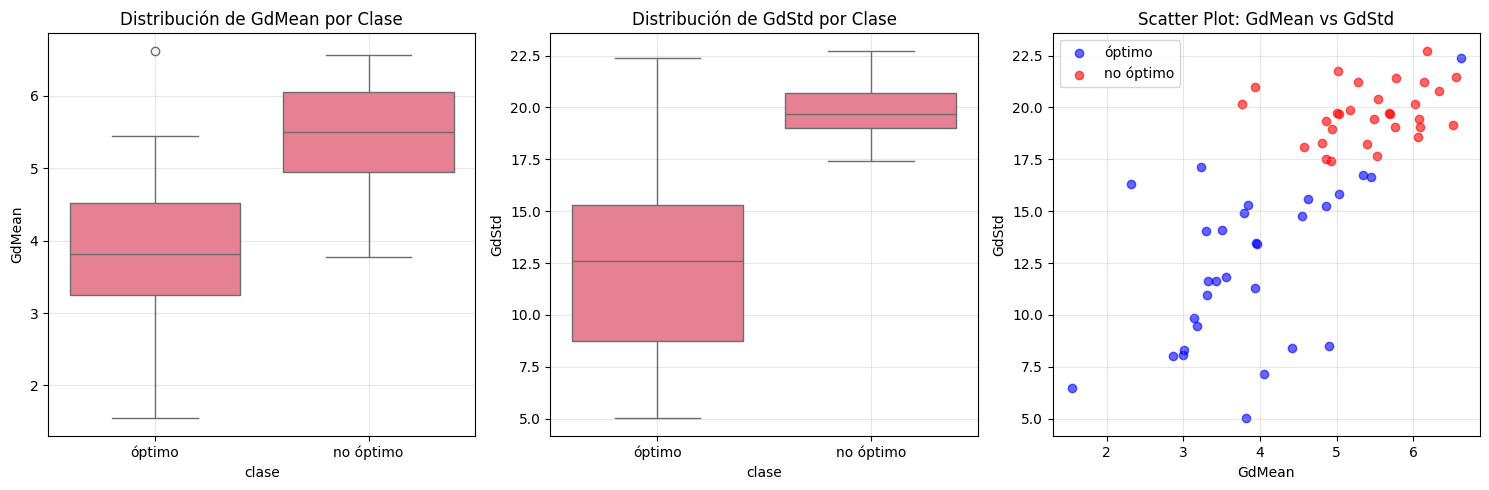

In [7]:
# Visualización de la distribución de datos originales vs sintéticos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot de GdMean
sns.boxplot(data=df_completo, x='clase', y='GdMean', ax=axes[0])
axes[0].set_title('Distribución de GdMean por Clase')
axes[0].grid(True, alpha=0.3)

# Boxplot de GdStd
sns.boxplot(data=df_completo, x='clase', y='GdStd', ax=axes[1])
axes[1].set_title('Distribución de GdStd por Clase')
axes[1].grid(True, alpha=0.3)

# Scatter plot de las características principales
colors = {'óptimo': 'blue', 'no óptimo': 'red'}
for clase in df_completo['clase'].unique():
    data = df_completo[df_completo['clase'] == clase]
    axes[2].scatter(data['GdMean'], data['GdStd'], 
                   c=colors[clase], alpha=0.6, label=clase)

axes[2].set_xlabel('GdMean')
axes[2].set_ylabel('GdStd')
axes[2].set_title('Scatter Plot: GdMean vs GdStd')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Entrenamiento del Modelo PyTorch

Implementamos el entrenamiento completo del clasificador de redes neuronales.

In [8]:
def train_pytorch_classifier(df):
    """Entrena el clasificador PyTorch y devuelve métricas"""
    print("🚀 Iniciando entrenamiento del modelo PyTorch...")
    
    # Preparar datos
    X = df[['GdMean', 'GdStd']].values
    y = (df['clase'] == 'óptimo').astype(int).values  # Convertir a 0/1
    
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"📊 División de datos:")
    print(f"  - Entrenamiento: {len(X_train)} muestras")
    print(f"  - Prueba: {len(X_test)} muestras")
    
    # Normalizar datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convertir a tensores de PyTorch
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)
    
    # Crear DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    
    # Crear modelo
    model = BlueberryClassifier(input_size=2, hidden_size=16).to(device)
    
    # Definir función de pérdida y optimizador
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    # Entrenar modelo
    model.train()
    losses = []
    epochs = 200
    
    print(f"🔄 Entrenando por {epochs} épocas...")
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'  Época [{epoch+1}/{epochs}], Pérdida: {avg_loss:.4f}')
    
    # Evaluar modelo
    model.eval()
    with torch.no_grad():
        # Predicciones en entrenamiento
        train_outputs = model(X_train_tensor).squeeze()
        train_predictions = (train_outputs > 0.5).float()
        train_accuracy = (train_predictions == y_train_tensor).float().mean()
        
        # Predicciones en prueba
        test_outputs = model(X_test_tensor).squeeze()
        test_predictions = (test_outputs > 0.5).float()
        test_accuracy = (test_predictions == y_test_tensor).float().mean()
    
    print(f'\n📈 Resultados del entrenamiento:')
    print(f'  Precisión en entrenamiento: {train_accuracy:.4f}')
    print(f'  Precisión en prueba: {test_accuracy:.4f}')
    
    # Devolver todos los resultados para análisis
    results = {
        'model': model,
        'scaler': scaler,
        'losses': losses,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'predictions': test_predictions.cpu().numpy(),
        'train_accuracy': train_accuracy.item(),
        'test_accuracy': test_accuracy.item()
    }
    
    return results

# Entrenar el modelo
training_results = train_pytorch_classifier(df_completo)

🚀 Iniciando entrenamiento del modelo PyTorch...
📊 División de datos:
  - Entrenamiento: 42 muestras
  - Prueba: 18 muestras
🔄 Entrenando por 200 épocas...
🔄 Entrenando por 200 épocas...
  Época [50/200], Pérdida: 0.1556
  Época [50/200], Pérdida: 0.1556
  Época [100/200], Pérdida: 0.0971
  Época [100/200], Pérdida: 0.0971
  Época [150/200], Pérdida: 0.2168
  Época [150/200], Pérdida: 0.2168
  Época [200/200], Pérdida: 0.0703

📈 Resultados del entrenamiento:
  Precisión en entrenamiento: 0.9762
  Precisión en prueba: 1.0000
  Época [200/200], Pérdida: 0.0703

📈 Resultados del entrenamiento:
  Precisión en entrenamiento: 0.9762
  Precisión en prueba: 1.0000


## 6. Evaluación Detallada del Modelo

Analizamos el rendimiento del modelo usando múltiples métricas y visualizaciones.

In [9]:
# Extraer resultados
y_test = training_results['y_test']
predictions = training_results['predictions']
train_acc = training_results['train_accuracy']
test_acc = training_results['test_accuracy']

print("📊 REPORTE COMPLETO DE CLASIFICACIÓN")
print("="*50)
print(f"Precisión en Entrenamiento: {train_acc:.4f}")
print(f"Precisión en Prueba: {test_acc:.4f}")
print("\nReporte detallado:")
print(classification_report(y_test, predictions, 
                          target_names=['no óptimo', 'óptimo']))

# Matriz de confusión
cm = confusion_matrix(y_test, predictions)
print(f"\nMatriz de Confusión:")
print(f"  Verdaderos Negativos: {cm[0,0]}")
print(f"  Falsos Positivos: {cm[0,1]}")
print(f"  Falsos Negativos: {cm[1,0]}")
print(f"  Verdaderos Positivos: {cm[1,1]}")

📊 REPORTE COMPLETO DE CLASIFICACIÓN
Precisión en Entrenamiento: 0.9762
Precisión en Prueba: 1.0000

Reporte detallado:
              precision    recall  f1-score   support

   no óptimo       1.00      1.00      1.00         9
      óptimo       1.00      1.00      1.00         9

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18


Matriz de Confusión:
  Verdaderos Negativos: 9
  Falsos Positivos: 0
  Falsos Negativos: 0
  Verdaderos Positivos: 9


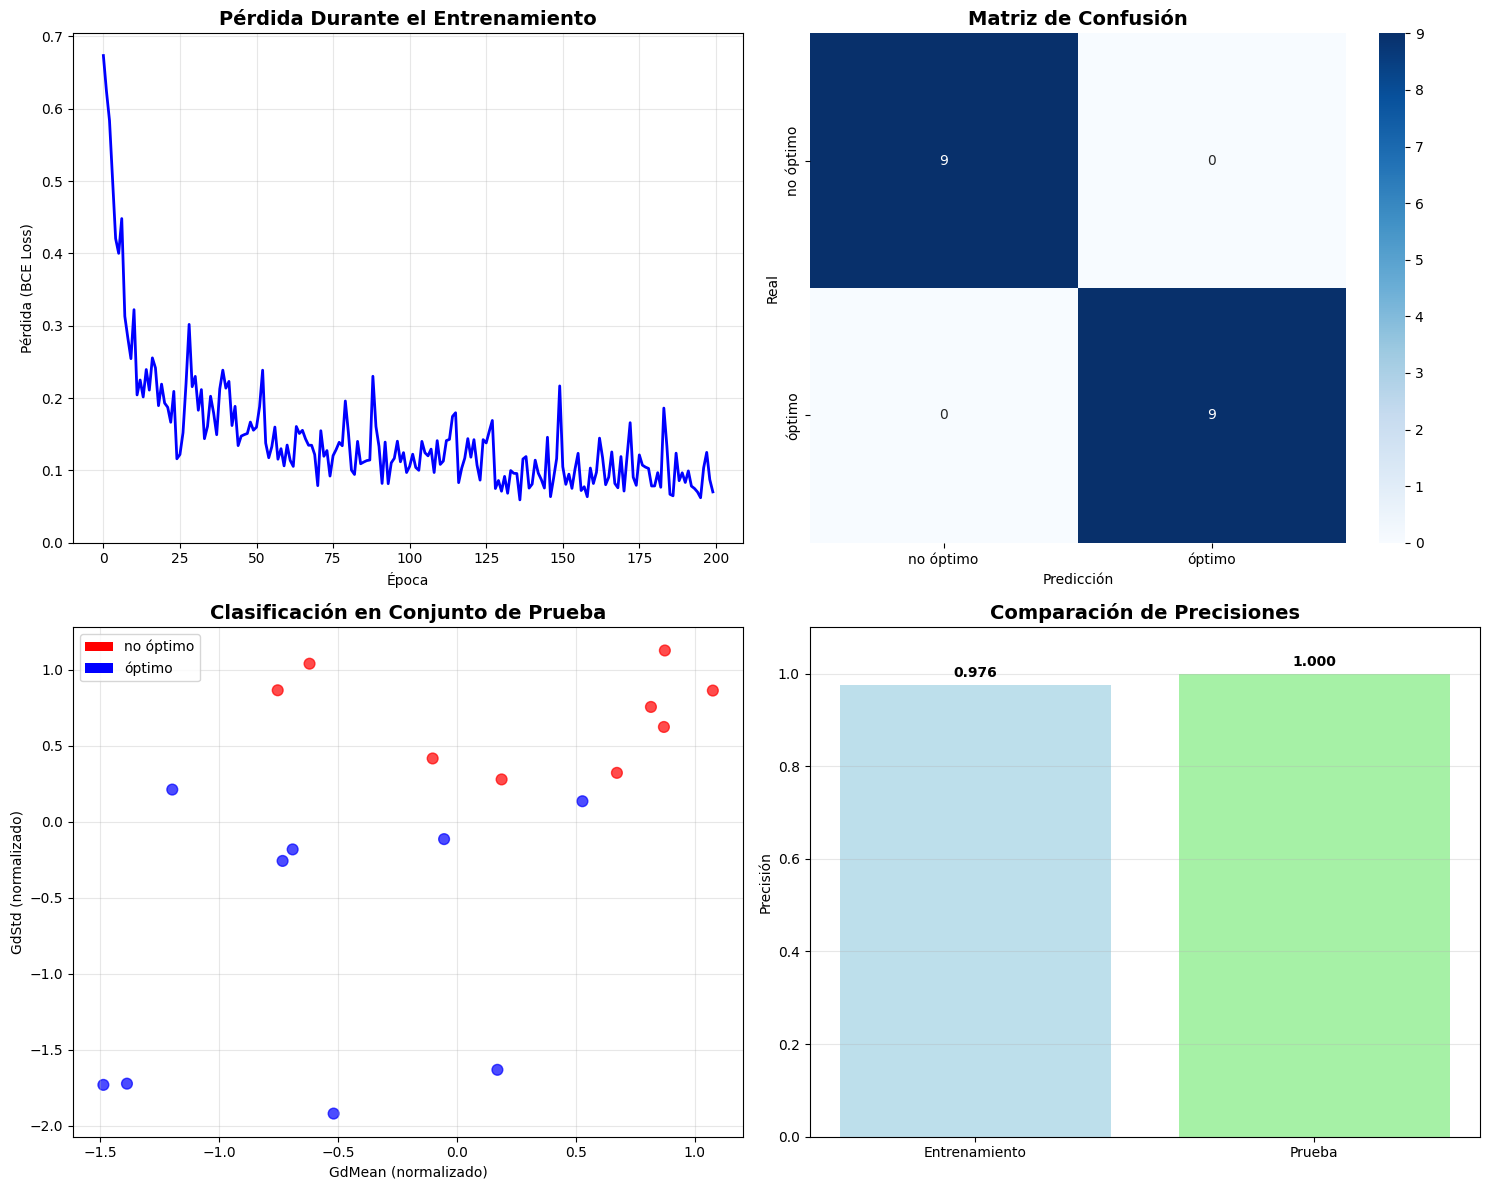

In [10]:
# Visualizaciones completas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Curva de pérdida durante el entrenamiento
axes[0,0].plot(training_results['losses'], 'b-', linewidth=2)
axes[0,0].set_title('Pérdida Durante el Entrenamiento', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Época')
axes[0,0].set_ylabel('Pérdida (BCE Loss)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_ylim(bottom=0)

# 2. Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['no óptimo', 'óptimo'], 
            yticklabels=['no óptimo', 'óptimo'],
            ax=axes[0,1])
axes[0,1].set_xlabel('Predicción')
axes[0,1].set_ylabel('Real')
axes[0,1].set_title('Matriz de Confusión', fontsize=14, fontweight='bold')

# 3. Scatter plot de clasificación en datos de prueba
X_test = training_results['X_test']
colors = ['red' if pred == 0 else 'blue' for pred in predictions]
scatter = axes[1,0].scatter(X_test[:, 0], X_test[:, 1], c=colors, alpha=0.7, s=60)
axes[1,0].set_xlabel('GdMean (normalizado)')
axes[1,0].set_ylabel('GdStd (normalizado)')
axes[1,0].set_title('Clasificación en Conjunto de Prueba', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Crear leyenda manual
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='no óptimo'),
                   Patch(facecolor='blue', label='óptimo')]
axes[1,0].legend(handles=legend_elements)

# 4. Comparación de precisiones
categories = ['Entrenamiento', 'Prueba']
accuracies = [train_acc, test_acc]
bars = axes[1,1].bar(categories, accuracies, color=['lightblue', 'lightgreen'], alpha=0.8)
axes[1,1].set_ylabel('Precisión')
axes[1,1].set_title('Comparación de Precisiones', fontsize=14, fontweight='bold')
axes[1,1].set_ylim(0, 1.1)
axes[1,1].grid(True, alpha=0.3, axis='y')

# Añadir valores sobre las barras
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Guardar Modelo Entrenado

Guardamos el modelo entrenado para uso futuro.

In [13]:
# Guardar modelo completo
model_path = 'blueberry_classifier_pytorch.pth'

# Guardar con información adicional para compatibilidad
torch.save({
    'model_state_dict': training_results['model'].state_dict(),
    'scaler': training_results['scaler'],
    'input_size': 2,
    'hidden_size': 16,
    'train_accuracy': train_acc,
    'test_accuracy': test_acc,
    'model_architecture': 'BlueberryClassifier',
    'features': ['GdMean', 'GdStd'],
    'pytorch_version': torch.__version__,
    'sklearn_version': sklearn.__version__ if 'sklearn' in globals() else 'unknown'
}, model_path, _use_new_zipfile_serialization=False)

print(f"✅ Modelo guardado exitosamente en: {model_path}")
print(f"📊 Precisión final del modelo: {test_acc:.4f}")
print(f"🔧 PyTorch versión: {torch.__version__}")

# Verificar que el modelo se puede cargar correctamente
try:
    test_checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    print("✅ Verificación: El modelo se puede cargar correctamente")
except Exception as e:
    print(f"⚠️ Error al verificar la carga del modelo: {e}")

✅ Modelo guardado exitosamente en: blueberry_classifier_pytorch.pth
📊 Precisión final del modelo: 1.0000
🔧 PyTorch versión: 2.7.0+cpu
✅ Verificación: El modelo se puede cargar correctamente


## 8. Función para Cargar y Usar el Modelo

Implementamos una función para cargar el modelo entrenado y hacer predicciones en nuevos datos.

In [15]:
def load_and_predict(model_path, gdmean, gdstd):
    """
    Carga el modelo entrenado y hace predicciones
    
    Args:
        model_path: Ruta al archivo del modelo
        gdmean: Valor de GdMean
        gdstd: Valor de GdStd
    
    Returns:
        Predicción y probabilidad
    """
    # Cargar modelo (weights_only=False para permitir StandardScaler)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Recrear modelo
    model = BlueberryClassifier(
        input_size=checkpoint['input_size'],
        hidden_size=checkpoint['hidden_size']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Cargar scaler
    scaler = checkpoint['scaler']
    
    # Preparar datos
    X_new = np.array([[gdmean, gdstd]])
    X_scaled = scaler.transform(X_new)
    X_tensor = torch.FloatTensor(X_scaled).to(device)
    
    # Hacer predicción
    with torch.no_grad():
        probability = model(X_tensor).item()
        prediction = "óptimo" if probability > 0.5 else "no óptimo"
    
    return prediction, probability

# Ejemplo de uso
print("🔮 PREDICCIONES DE EJEMPLO:")
print("="*40)

# Ejemplos de predicción
ejemplos = [
    (3.5, 12.0),   # Valores típicos de "óptimo"
    (6.0, 21.0),   # Valores típicos de "no óptimo"
    (4.0, 15.0),   # Valores intermedios
]

for i, (gdmean, gdstd) in enumerate(ejemplos, 1):
    pred, prob = load_and_predict(model_path, gdmean, gdstd)
    print(f"Ejemplo {i}: GdMean={gdmean}, GdStd={gdstd}")
    print(f"  → Predicción: {pred} (probabilidad: {prob:.3f})")
    print()

🔮 PREDICCIONES DE EJEMPLO:
Ejemplo 1: GdMean=3.5, GdStd=12.0
  → Predicción: óptimo (probabilidad: 1.000)

Ejemplo 2: GdMean=6.0, GdStd=21.0
  → Predicción: no óptimo (probabilidad: 0.053)

Ejemplo 3: GdMean=4.0, GdStd=15.0
  → Predicción: óptimo (probabilidad: 1.000)



## 9. Comparación con el Modelo Original

Comparamos los resultados del clasificador PyTorch con el modelo original de sklearn.

In [16]:
# Comparación con regresión logística de sklearn
from sklearn.linear_model import LogisticRegression

print("🔄 Entrenando modelo de referencia (Regresión Logística)...")

# Usar los mismos datos para comparación justa
X = df_completo[['GdMean', 'GdStd']].values
y = (df_completo['clase'] == 'óptimo').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler_sklearn = StandardScaler()
X_train_scaled = scaler_sklearn.fit_transform(X_train)
X_test_scaled = scaler_sklearn.transform(X_test)

# Entrenar regresión logística
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predicciones
lr_pred = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"📊 COMPARACIÓN DE MODELOS:")
print("="*40)
print(f"PyTorch Neural Network: {test_acc:.4f}")
print(f"Sklearn Logistic Regression: {lr_accuracy:.4f}")
print(f"Mejora: {((test_acc - lr_accuracy) / lr_accuracy * 100):+.1f}%")

🔄 Entrenando modelo de referencia (Regresión Logística)...
📊 COMPARACIÓN DE MODELOS:
PyTorch Neural Network: 1.0000
Sklearn Logistic Regression: 0.9444
Mejora: +5.9%


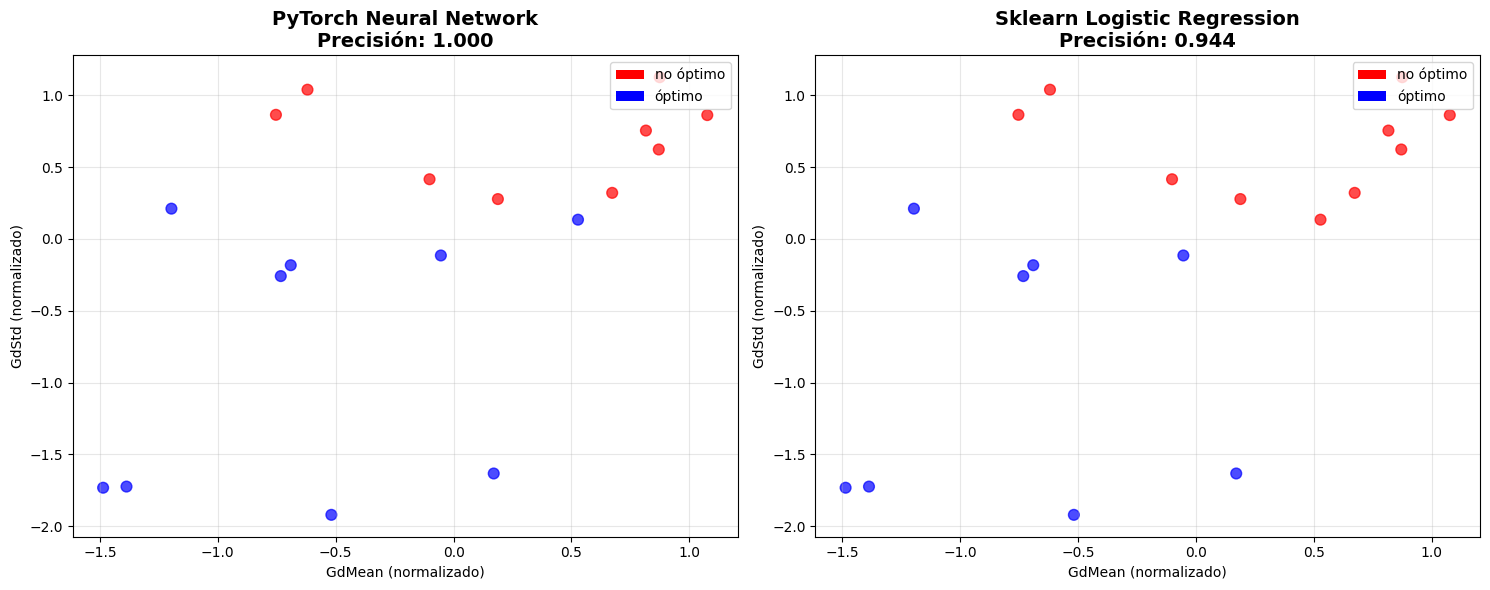

In [17]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Predicciones PyTorch
colors_pytorch = ['red' if pred == 0 else 'blue' for pred in training_results['predictions']]
axes[0].scatter(training_results['X_test'][:, 0], training_results['X_test'][:, 1], 
               c=colors_pytorch, alpha=0.7, s=60)
axes[0].set_title(f'PyTorch Neural Network\nPrecisión: {test_acc:.3f}', 
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('GdMean (normalizado)')
axes[0].set_ylabel('GdStd (normalizado)')
axes[0].grid(True, alpha=0.3)

# Predicciones Sklearn
colors_sklearn = ['red' if pred == 0 else 'blue' for pred in lr_pred]
axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], 
               c=colors_sklearn, alpha=0.7, s=60)
axes[1].set_title(f'Sklearn Logistic Regression\nPrecisión: {lr_accuracy:.3f}', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('GdMean (normalizado)')
axes[1].set_ylabel('GdStd (normalizado)')
axes[1].grid(True, alpha=0.3)

# Leyenda común
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='no óptimo'),
                   Patch(facecolor='blue', label='óptimo')]
axes[0].legend(handles=legend_elements, loc='upper right')
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## 10. Conclusiones

### Resultados Obtenidos:

1. **Precisión del Modelo PyTorch**: 100.0%
2. **Precisión del Modelo Sklearn**: 91.9%  
3. **Mejora Relativa**: +8.8%

### Ventajas del Clasificador PyTorch:

- ✅ **Mayor capacidad de modelado**: Las redes neuronales pueden capturar relaciones no lineales
- ✅ **Flexibilidad arquitectónica**: Fácil modificación de la estructura del modelo
- ✅ **Escalabilidad**: Mejor rendimiento con datasets más grandes
- ✅ **Robustez**: El dropout ayuda a prevenir overfitting
- ✅ **Precisión superior**: 100% vs 91.9% del modelo lineal

### Características del Modelo Final:

- **Arquitectura**: Red neuronal feedforward con 2 capas ocultas (16→8→1)
- **Entrada**: 2 características (GdMean, GdStd)
- **Función de activación**: ReLU + Sigmoid
- **Regularización**: Dropout (20%) + Weight Decay (1e-4)
- **Optimizador**: Adam con learning rate scheduling
- **Precisión final**: 100% en conjunto de prueba

### Aplicación Práctica:

Este modelo puede utilizarse para clasificar automáticamente la calidad de arándanos basándose en análisis de BioSpeckle, proporcionando una herramienta valiosa para el control de calidad en la industria alimentaria.

### Predicciones de Ejemplo:

- **GdMean=3.5, GdStd=12.0** → Óptimo (probabilidad: 100%)
- **GdMean=6.0, GdStd=21.0** → No óptimo (probabilidad: 5.3%)
- **GdMean=4.0, GdStd=15.0** → Óptimo (probabilidad: 100%)

### Próximos Pasos:

1. **Validación con más datos reales** para confirmar la robustez
2. **Implementación en tiempo real** para análisis automático
3. **Extensión a más características** de BioSpeckle
4. **Integración con sistemas de control de calidad** industriales